# Imports and Defined new functoins

## Imports

**This code is being run is SPARCL in Astro Data Lab's Jupyter Notebook :** https://datalab.noirlab.edu/about.php

https://pypi.org/project/sparclclient/

-------------------------------------------------------------------------------------------

In [2]:
# import sparcl.client
from sparcl.client import SparclClient

# import the required libraries
import numpy as np
import astropy as astro
from astropy.io import fits
import astropy.units as u
from specutils import Spectrum1D
from astropy.nddata import InverseVariance
from astropy.convolution import convolve, Gaussian1DKernel
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import math
import extinction

# import for SPARCL login
from dl import queryClient as qc
from dl import authClient as ac
from getpass import getpass

# for getting standard plots
plt.rc_context({'lines.linewidth': 1, 'lines.linestyle': '-'})
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (14,8)

In [3]:
client = SparclClient()
client

(sparclclient:1.2.2, api:12.0, https://astrosparcl.datalab.noirlab.edu/sparc, client_hash=, verbose=False, connect_timeout=1.1, read_timeout=5400.0)

-------------------------------------------------------------------------------------------

## Defined Functions

### rec

In [4]:
# to record all results after redshifting with logarithmic wavelength data

def rec(result, limit):

    list_of_specid = []
    
    log_full_data = []
    all_sum = 0
    
    for i in range(limit):

        record = result.records[i]
        list_of_specid.append(record.specid)
        
        flux = record.flux
        inv_var = record.ivar # inverse variance (tells about the error)
        z = record.redshift

        # redshifting can be deduced from z = (λ_observed - λ_emitted) / λ_emitted
        wavelength_obs = record.wavelength
        wavelength_emit = wavelength_obs/(1+z)
        log_wavelength = np.array([math.log(w) for w in wavelength_emit])
        
        log_diff_mean = (log_wavelength[-1] - log_wavelength[0]) / len(log_wavelength)
        all_sum = all_sum + log_diff_mean

        log_data_obj = []
        for x in range(len(log_wavelength)):
            data_point = [log_wavelength[x],inv_var[x],flux[x]]
            log_data_obj.append(data_point)

        log_full_data.append(log_data_obj)

    # this will give us the bins of very high resolution
    all_log_diff_mean = all_sum / limit
    bin_sz = all_log_diff_mean
    
    return log_full_data, bin_sz, list_of_specid

### deredden_flux

**Using extinction.ccm89 model to deredden the flux**

https://pypi.org/project/extinction/

In [5]:
# this is to deredden the flux using the above model
# ebv needs to be a list of float values that need to be given

def deredden_flux(reddened_data, limit, ebv_given):

    dereddened_data_all = []
    
    for x in range(limit):
        ebv = ebv_given[x]
        log_wavelength = np.array([row[0] for row in reddened_data[x]])
        wavelength = (np.e)**log_wavelength
        inv_var = np.array([row[1] for row in reddened_data[x]])
        flux = np.array([row[2] for row in reddened_data[x]])
        
        # wavelengths for format
        wavelength = wavelength.astype(np.float64)
    
        # Calculating dust dimming in each color
        extinction_curve = extinction.ccm89(wavelength, a_v=3.1*ebv, r_v=3.1)

        # brightness adjustment
        dereddened_flux = flux * 10 ** (0.4 * extinction_curve)

        dereddened_data = np.hstack([log_wavelength[:,np.newaxis],inv_var[:,np.newaxis],dereddened_flux[:,np.newaxis]])
        dereddened_data_all.append(dereddened_data.tolist())

    return dereddened_data_all

### same_range

In [6]:
# to make the data lie in required range of wavelength

def same_range(all_dereddened_data, min_wv, max_wv):
    
    log_min_wv = math.log(min_wv)
    log_max_wv = math.log(max_wv)
    log_fix_data = []
    
    for data_pt in all_dereddened_data:
        if log_min_wv <= data_pt[0] <= log_max_wv:
            log_fix_data.append(data_pt)

    return log_fix_data

### bin_make

In [7]:
# to create bins of equal log width (the highest resolution)

def bin_make(bin_sz, min_wv, max_wv):

    log_min_wv = math.log(min_wv)
    log_max_wv = math.log(max_wv)

    num_bins = int(np.ceil((log_max_wv - log_min_wv) / bin_sz)) + 1
    start = log_min_wv - (bin_sz/2)
    stop = log_max_wv + (bin_sz/2)
    
    bin_edges = np.linspace(start, stop, num_bins)
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return bin_edges, bin_centers

### binning

In [8]:
# binning the flux data into according to the new bins

def binning(log_fix_data, bin_edges):

    binned_data = []
    
    for b in range(len(bin_edges) - 1):
        pnts_in_a_bin = []
        for data_pt in log_fix_data:
            if bin_edges[b] <= data_pt[0] <= bin_edges[b+1]:
                pnts_in_a_bin.append(data_pt)
        binned_data.append(pnts_in_a_bin)
    
    return binned_data

### sigma_clipping

In [9]:
# general recursive function for sigma clipping for 1D data (to be put in a loop)

def sigma_clipping(data_bef, n, tolerance):

    if len(data_bef) <= 1:
        return data_bef

    flux_in_bin_bef = [row[2] for row in data_bef]
    
    std_0 = np.std(flux_in_bin_bef)
    median_0 = np.median(flux_in_bin_bef)
    lower, upper = (median_0 - n*std_0), (median_0 + n*std_0)
    
    data_aft = []
    for d in data_bef:
        if lower <= d[2] <= upper:
            data_aft.append(d)

    flux_in_bin_aft = [row[2] for row in data_aft]
    
    std_1 = np.std(data_aft)
    relative_std_1 = (std_0/std_1)-1
    
    if (relative_std_1 <= tolerance):
        return data_aft
    else:
        return sigma_clipping(data_aft, n, tolerance)

### inv_var_data

In [10]:
# this is the code to find inverse variance of the final flux data (to be put in a loop)

def inv_var_data(data):

    flux_of_data = [row[2] for row in data]
    
    variance = np.var(flux_of_data)
    
    if variance != 0:
        new_inv_var = 1/variance
    elif variance == 0:
        new_inv_var = -1   # shows one or zero values
        
    return new_inv_var

### weigh_mean

In [11]:
# to take weighted mean in all the bins using inverse variance in the data given as ivar for every point

def weigh_mean(clipped_binned_data):

    weighed_flux_all = []
    status = []
    
    for one_bin_data in clipped_binned_data:
        
        fluxes_in_bin = [data_pt[1] for data_pt in one_bin_data]
        fluxes_sum = np.sum(fluxes_in_bin)

        ivars_in_bin = [data_pt[2] for data_pt in one_bin_data]
        ivars_sum = np.sum(ivars_in_bin)
        
        if ivars_sum != 0:
            products = [x * y for x, y in zip(fluxes_in_bin, ivars_in_bin)] # does pairwise product
            weighed_flux = np.sum(products)/ivars_sum
            weighed_flux_all.append(weighed_flux)
            status.append('weighted (low error)')
            
        elif ivars_sum == 0 and fluxes_sum != 0 :
            weighed_flux = fluxes_sum/len(fluxes_in_bin)
            weighed_flux_all.append(weighed_flux)
            status.append('high error')
            
        else:
            weighed_flux_all.append(0)
            status.append('no data available')
    
    return weighed_flux_all, status

-------------------------------------------------------------------------------------------

# Sample Code

## Calculations

### data collection

**Take data from this code if you only require specific conditions rather than data for specific ids**

In [12]:
# out are the fields you want to view
out = ['sparcl_id', 'specid', 'redshift', 'data_release', 'dec', 'ra']

# cons are the coditions that you can set
cons = {'spectype': ['QSO'],# Can be set to 'GALAXY', 'QSO', 'sTAR' 
        'data_release': ['SDSS-DR16'],# can be set to 'SDSS-DR16', 'BOSS-DR16', 'DESI-EDR'
        'dec': [0,10],# can be set from -90 to +90 degrees
        'ra': [0,10],# can be set to 0 to 360 degrees
        'redshift': [0.6, 1.1]}# can be set to required range

# points are the number of Galaxies/QSOs/Stars you want the data for
points = 100

# sort puts the data in order
found_I = client.find(outfields=out, constraints=cons, limit=points, sort='redshift')

# put more %s, %f for string and float accordingly for other outfields you want
["%s, %s, %s, %f, %f, %f" % (f.sparcl_id, f.specid, f.data_release, f.redshift, f.dec, f.ra)
for f in found_I.records]

['1cc819fa-9f7b-11ee-86f2-525400ad1336, 1735108301202417664, SDSS-DR16, 0.603912, 0.247254, 2.511053',
 '1e818d9c-9f17-11ee-9606-525400ad1336, 1222832619431946240, SDSS-DR16, 0.609892, 0.631364, 8.012426',
 'c8165dca-9eb0-11ee-a1ff-525400ad1336, 772462211233769472, SDSS-DR16, 0.614817, 0.428672, 0.916808',
 'f295c59d-9f20-11ee-ad22-525400ad1336, 1275735079498311680, SDSS-DR16, 0.619256, 0.787531, 7.906147',
 '6eb422ff-a036-11ee-9b4a-525400ad1336, 2620117854413940736, SDSS-DR16, 0.619771, 7.920922, 9.800401',
 '90a99350-9eb1-11ee-a6fd-525400ad1336, 775888285154174976, SDSS-DR16, 0.620761, 1.256880, 8.014523',
 '2fdbde66-9e5e-11ee-90b3-525400ad1336, 439267570147682304, SDSS-DR16, 0.623454, 1.135968, 5.959090',
 '6c84b912-9e5e-11ee-bc43-525400ad1336, 439266746923247616, SDSS-DR16, 0.623891, 1.135968, 5.959090',
 '20cafb9e-9f17-11ee-aef9-525400ad1336, 1222843339670317056, SDSS-DR16, 0.630835, 0.248226, 8.525639',
 'c932d7f9-9eb0-11ee-95b9-525400ad1336, 772466609280280576, SDSS-DR16, 0.6326

**If you require data for specific objects then put them in a list and take uuid_list = desired_list**


In [13]:
# 'inc' tells the required details to be included in the result
inc = ['sparcl_id', 'specid', 'data_release', 'redshift', 'flux', 'wavelength', 'ivar']

desired_ids = [773658754745919488, 1222859007711012864, 776981199695407104]

results_II = client.retrieve_by_specid(specid_list=desired_ids,
                                       include=inc)
results_II.info

{'status': {'success': True,
  'info': ["Successfully found 3 records in dr_list={'BOSS-DR16', 'SDSS-DR16', 'DESI-EDR'}"],
  'warnings': []}}

### including data parameters

In [14]:
# 'inc' tells the required details to be included in the result
inc = ['sparcl_id', 'specid', 'data_release', 'redshift', 'flux', 'wavelength', 'ivar']

# list of all the IDs in the data found (change to desired_ids if required)
ids_I = found_I.ids

# retrieve the details listed in 'inc' for IDs in uuid_list
results_I = client.retrieve(uuid_list=ids_I, include=inc)

results_I.info

{'status': {'success': True,
  'info': ["Successfully found 100 records in dr_list={'BOSS-DR16', 'SDSS-DR16', 'DESI-EDR'}"],
  'warnings': []}}

### rec use

In [15]:
log_data, bin_size, specids_list = rec(result = results_I,
                                       limit = points)

### deredden_flux use

In [16]:
# ebv should be a list of the length equal to points(galaxies etc)
ebv_list = [0.1]*100


dereddened_data = deredden_flux(reddened_data = log_data,
                                limit = points,
                                ebv_given = ebv_list)

dereddened_data_2D = []

for i in dereddened_data:
    for j in i:
        dereddened_data_2D.append(j)

### same_range use

In [17]:
fixed_log_wavelength = same_range(all_dereddened_data = dereddened_data_2D,
                                  min_wv = 2440,
                                  max_wv = 6000)

### bin_make use

In [18]:
bin_sides, bin_mids = bin_make(bin_sz = bin_size,
                               min_wv = 2440,
                               max_wv = 6000)

### binning use

In [19]:
wave_bins = binning(log_fix_data = fixed_log_wavelength,
                    bin_edges = bin_sides)

### sigma_clipping and inv_var_data use

In [21]:
clipped_data_full = []
inv_var_list = []
for one_bin in wave_bins:
    clipped_data = sigma_clipping(data_bef = one_bin,
                                  n = 3,
                                  tolerance = 0.7)
    bin_ivar = inv_var_data(data = clipped_data)
    clipped_data_full.append(clipped_data)
    inv_var_list.append(bin_ivar)

### weigh_mean use

In [22]:
final_flux, error_str = weigh_mean(clipped_binned_data = clipped_data_full)

## Plotting

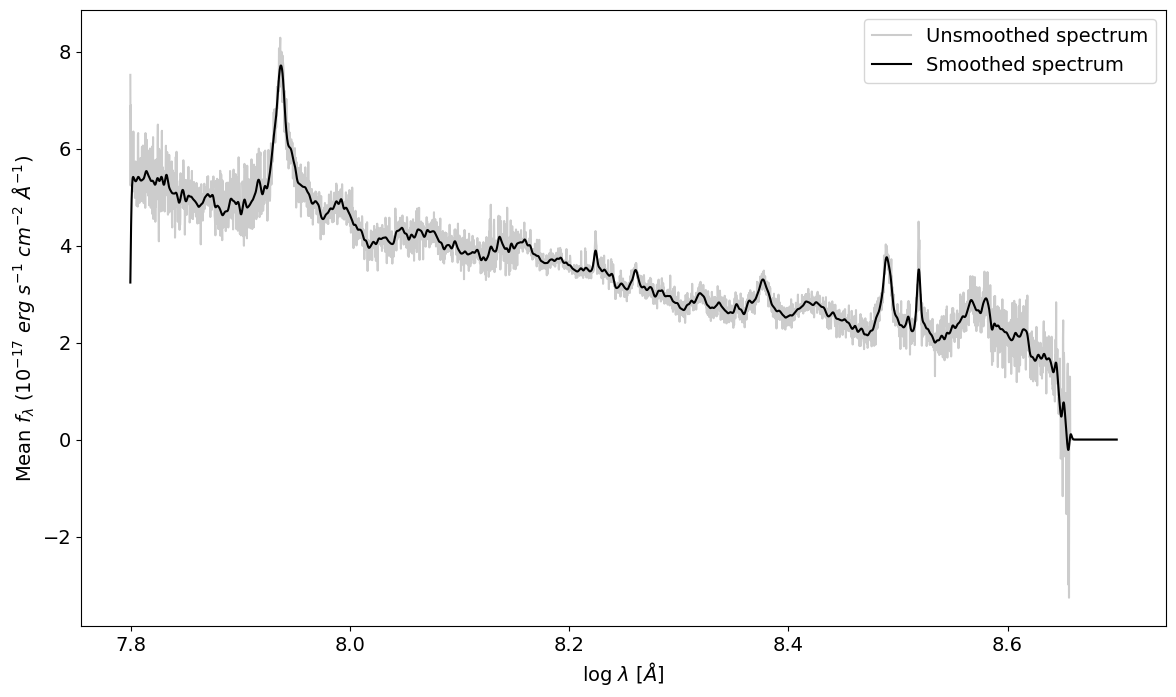

In [42]:
clipped_flux = []
for x in clipped_data_full:
    l = [row[2] for row in x]
    if len(l)!=0: p = sum(l)/len(l)
    else: p = 0
    clipped_flux.append(p)

# Plot unsmoothed spectrum in grey
plt.plot(bin_mids, clipped_flux, color='k', alpha=0.2, label='Unsmoothed spectrum')

# Overplot spectrum smoothed using a 1-D Gaussian Kernel in black
plt.plot(bin_mids, convolve(clipped_flux, Gaussian1DKernel(5)), color='k', label='Smoothed spectrum')

plt.xlabel('log $\lambda\ [\AA]$')
plt.ylabel('Mean $f_{\lambda}$ $(10^{-17}$ $erg$ $s^{-1}$ $cm^{-2}$ $\AA^{-1})$')

plt.legend()
plt.show()

[773587011612207104, 1679932595275589632, 773602679652902912, 1266799616884500480, 1227289221279016960, 1679944689903495168, 773632091588945920, 2144938339197806592, 1227338699302266880, 1679992793537210368, 1679994992560465920, 1227341722959243264, 1735108301202417664, 1222832619431946240, 1735116547539625984, 1222843339670317056, 1222843889426130944, 1735150907277993984, 753316965149337600, 1222885945745893376, 1735167949708224512, 439247229182568448, 439255475519776768, 439267570147682304, 1263357600263596032, 1276918972788271104, 1259991989902927872, 774740668902828032, 774748090606315520, 774753863042361344, 2144937791002273792, 3497080923868995584, 2620048035425576960, 1228501707709769728, 1223977217831233536, 1228505281122560000, 1223998658307975168, 439247230591854592, 2620093665158129664, 439256851318597632, 439260424731387904, 439266746923247616, 2620108783443011584, 3497183728206192640, 2620117854413940736, 753351875180390400, 2620122527338358784, 753375789558294528, 1268979

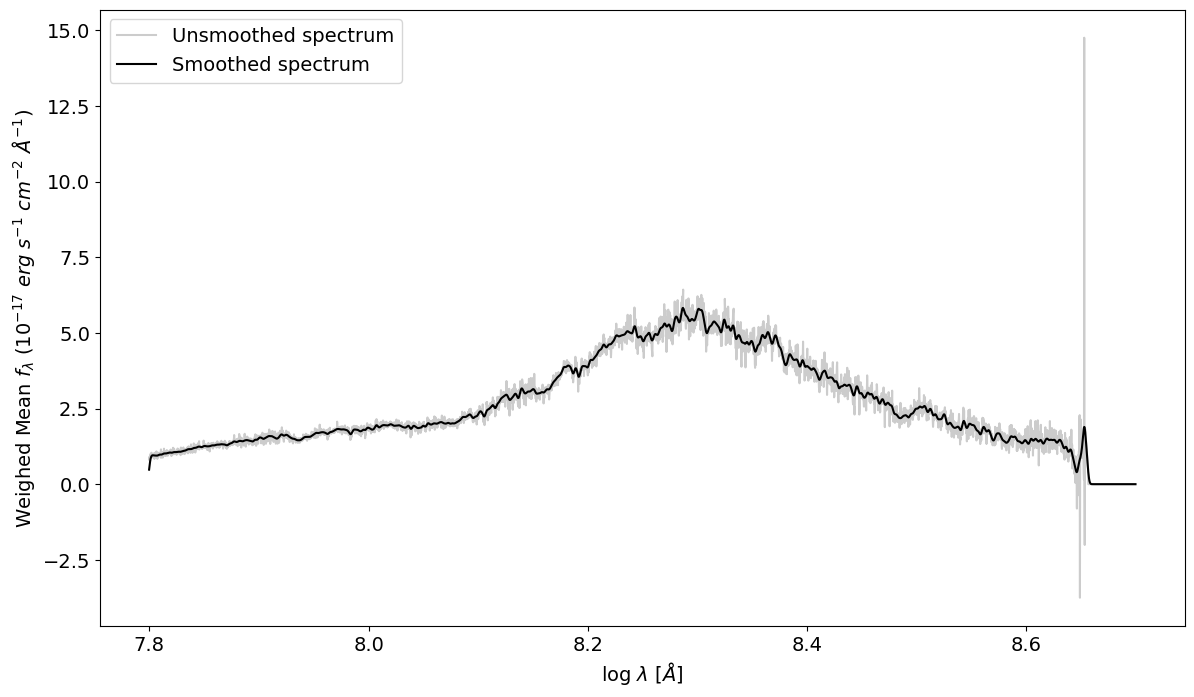

In [32]:
print(specids_list)
plt.xlabel('log $\lambda\ [\AA]$')
plt.ylabel('Weighed Mean $f_{\lambda}$ $(10^{-17}$ $erg$ $s^{-1}$ $cm^{-2}$ $\AA^{-1})$')

# Plot unsmoothed spectrum in grey
plt.plot(bin_mids, final_flux, color='k', alpha=0.2, label='Unsmoothed spectrum')

# Overplot spectrum smoothed using a 1-D Gaussian Kernel in black
plt.plot(bin_mids, convolve(final_flux, Gaussian1DKernel(5)), color='k', label='Smoothed spectrum')
    
plt.legend()
plt.show()